# Data visualization

### Import packages

In [1]:
# Third party packages.
import os                       # Execute tasks related to your operating system.

import pandas as pd             # Data handling.
import polars as pl             # Data handling ('Blazingly fast DataFrames'), alternative to Pandas.
import polars.selectors as cs   # Select columns of particular type.
import numpy as np              # numerical calculations.
import pickle                   # Save and load data to and from pickle files.
# import altair as alt            # Visualize data
import seaborn as sns           # Visualize data
import matplotlib.pyplot as plt # Visualize data

# from icecream import ic          # Print variables.

# from scipy.stats import pearsonr # Correlation

# Import functions from Pieter's utils package.
# from utils_pieter import f_heatmap, f_plot_scatter_with_trend_grid

### Load objects from earlier exercise

In [4]:
with open('../data/1_bronze/dc-uwv-80072ned.pkl', 'rb') as pickle_file:
    dc_uwv_80072ned = pickle.load(pickle_file)

enriched_fact  = dc_uwv_80072ned['enriched_fact']
l_df_num_names = dc_uwv_80072ned['l_df_num_names']
l_df_str_names = dc_uwv_80072ned['l_df_str_names']

In [5]:
enriched_fact

,ID,BedrijfskenmerkenSBI2008,Perioden,Ziekteverzuimpercentage_1,Title,Description,Status,Key_bedrijfs,Title_bedrijfs,Description_bedrijfs,CategoryGroupID,ID_category,DimensionKey,Title_category,Description_category,ParentID
0,0,T001081,1996KW01,5.5,1996 1e kwartaal,,Definitief,T001081,A-U Alle economische activiteiten,Alle economische activiteiten \r\nDeze categor...,1,1,BedrijfskenmerkenSBI2008,Totaal,,0
1,1,T001081,1996KW02,4.6,1996 2e kwartaal,,Definitief,T001081,A-U Alle economische activiteiten,Alle economische activiteiten \r\nDeze categor...,1,1,BedrijfskenmerkenSBI2008,Totaal,,0
2,2,T001081,1996KW03,4.0,1996 3e kwartaal,,Definitief,T001081,A-U Alle economische activiteiten,Alle economische activiteiten \r\nDeze categor...,1,1,BedrijfskenmerkenSBI2008,Totaal,,0
3,3,T001081,1996KW04,4.7,1996 4e kwartaal,,Definitief,T001081,A-U Alle economische activiteiten,Alle economische activiteiten \r\nDeze categor...,1,1,BedrijfskenmerkenSBI2008,Totaal,,0
4,4,T001081,1996JJ00,4.7,1996,,Definitief,T001081,A-U Alle economische activiteiten,Alle economische activiteiten \r\nDeze categor...,1,1,BedrijfskenmerkenSBI2008,Totaal,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,5767,WP19098,2024KW04,6.3,2024 4e kwartaal,,Definitief,WP19098,100 of meer werkzame personen,"Het aantal ""werkzame personen"" bestaat uit: \r...",5,5,BedrijfskenmerkenSBI2008,Bedrijfsgrootte,None,0
5768,5768,WP19098,2024JJ00,6.1,2024,,Definitief,WP19098,100 of meer werkzame personen,"Het aantal ""werkzame personen"" bestaat uit: \r...",5,5,BedrijfskenmerkenSBI2008,Bedrijfsgrootte,None,0
5769,5769,WP19098,2025KW01,6.8,2025 1e kwartaal,Voorlopige cijfers,Voorlopig,WP19098,100 of meer werkzame personen,"Het aantal ""werkzame personen"" bestaat uit: \r...",5,5,BedrijfskenmerkenSBI2008,Bedrijfsgrootte,None,0
5770,5770,WP19098,2025KW02,6.0,2025 2e kwartaal,Voorlopige cijfers,Voorlopig,WP19098,100 of meer werkzame personen,"Het aantal ""werkzame personen"" bestaat uit: \r...",5,5,BedrijfskenmerkenSBI2008,Bedrijfsgrootte,None,0


### We need to change some data types in df_80072ned to be used in time series plots

In [6]:
def parse_period(period: str) -> tuple[int, int]:
    """
    Parse CBS period codes to (year, quarter).
    
    Supported formats:
    - 2024KW01: Quarter (Kwartaal) - returns (2024, 1)
    - 2024JJ00: Year (Jaar) - returns (2024, 0) where 0 indicates annual data
    
    Returns:
        tuple[int, int]: (year, quarter) where quarter is 0 for annual data
    """
    year = int(period[0:4])
    
    if 'KW' in period:
        quarter = int(period[6:8])
        return (year, quarter)
    elif 'JJ' in period:
        return (year, 0)
    else:
        raise ValueError(f"Unknown period format: {period}. Expected 'KW' (quarter) or 'JJ' (year).")

In [9]:
# Apply parse_period to create year and quarter columns
df_80072ned = enriched_fact.copy()
df_80072ned[['year', 'quarter']] = df_80072ned['Perioden'].apply(parse_period).apply(pd.Series)


### Create some plots

#### Create a time series plot using seaborn to show 'totaal ziekteverzuim' (category 1) over the years

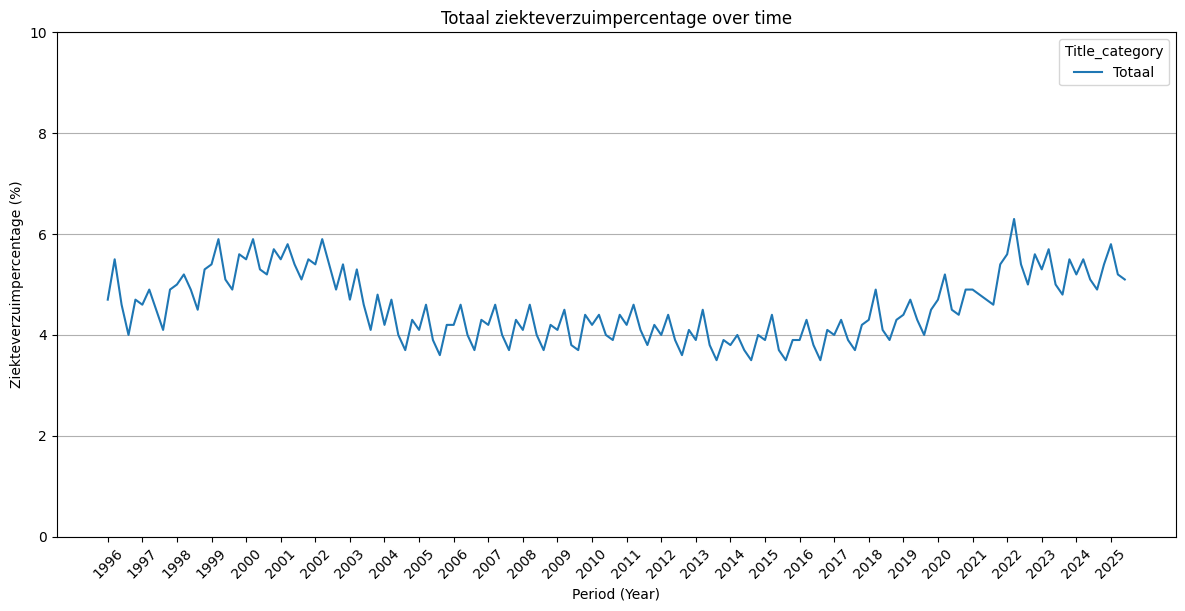

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for CategoryGroupID == 1
df_plot = df_80072ned[df_80072ned["CategoryGroupID"] == 1].copy()

# Ensure the relevant columns exist
if "Ziekteverzuimpercentage_1" not in df_plot.columns:
    raise ValueError("Column 'Ziekteverzuimpercentage_1' not found in DataFrame.")

# Create a 'period' column for x-axis (e.g., '2020Q1', '2020Q2', ...)
df_plot["period"] = df_plot["year"].astype(str) + "Q" + df_plot["quarter"].astype(str)
df_plot = df_plot.sort_values(["year", "quarter"])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x='period', y='Ziekteverzuimpercentage_1', hue='Title_category')

plt.xlabel("Period (Year)")
plt.ylabel("Ziekteverzuimpercentage (%)")
plt.title("Totaal ziekteverzuimpercentage over time")
plt.tight_layout()
plt.ylim(0, 10)
plt.grid('major', axis='y')

# Limit x-axis labels to years
periods_unique = df_plot['period'].unique()
years_unique = df_plot.drop_duplicates(subset=['period'])['year'].values
xtick_positions = []
xtick_labels = []
current_year = None
for i, year in enumerate(years_unique):
    if year != current_year:
        period_idx = list(periods_unique).index(periods_unique[i])
        xtick_positions.append(period_idx)
        xtick_labels.append(str(year))
        current_year = year
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.show()


#### Create a time series plot using seaborn to show ziekteverzuim over the years per sector (category = 2)


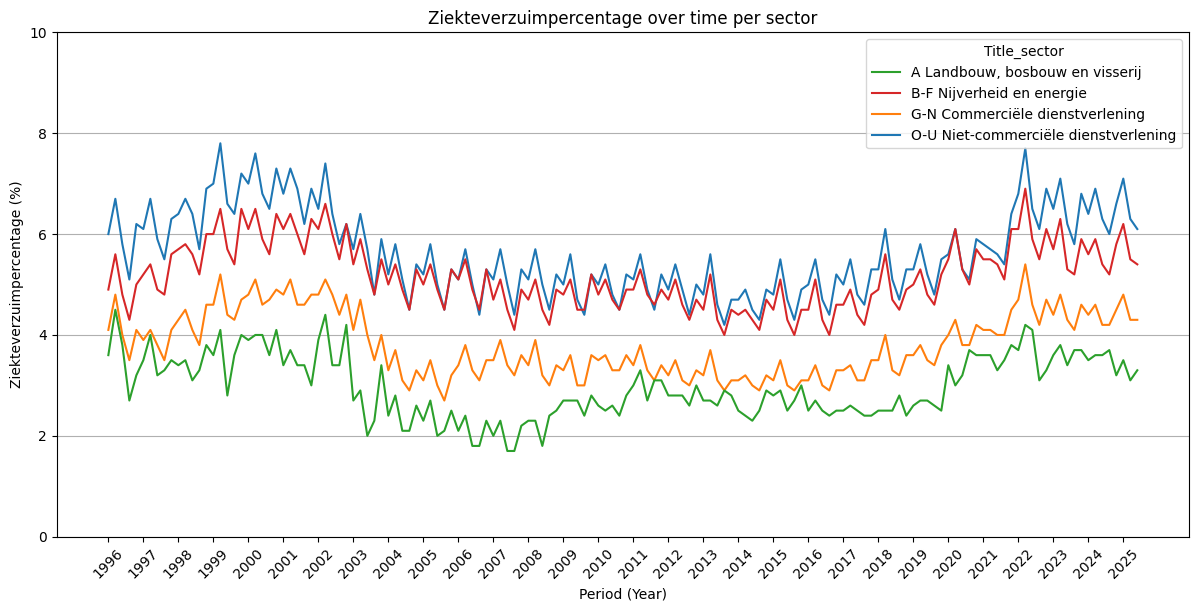

In [86]:
# Filter for CategoryGroupID == 1
df_plot = df_80072ned.filter(pl.col("CategoryGroupID") == 2)

# Ensure the relevant columns exist
if "Ziekteverzuimpercentage_1" not in df_plot.columns:
    raise ValueError("Column 'Ziekteverzuimpercentage_1' not found in DataFrame.")

# Create a 'period' column for x-axis (e.g., '2020Q1', '2020Q2', ...)
df_plot = df_plot.with_columns([
    (pl.col("year").cast(str) + "Q" + pl.col("quarter").cast(str)).alias("period")
]).sort(["year", "quarter"])

# Convert to pandas for seaborn
df_plot_pd = df_plot.to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot_pd, x='period', y='Ziekteverzuimpercentage_1', hue='Title_sector')

# Sort the legend alphabetically
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, title='Title_sector')

plt.xlabel("Period (Year)")
plt.ylabel("Ziekteverzuimpercentage (%)")
plt.title("Ziekteverzuimpercentage over time per sector")
plt.tight_layout()
plt.ylim(0, 10)
plt.grid('major', axis='y')

# Limit x-axis labels to years
periods_unique = df_plot_pd['period'].unique()
years_unique = df_plot_pd.drop_duplicates(subset=['period'])['year'].values
xtick_positions = []
xtick_labels = []
current_year = None
for i, year in enumerate(years_unique):
    if year != current_year:
        # Find the index of this period in the full periods list
        period_idx = list(periods_unique).index(periods_unique[i])
        xtick_positions.append(period_idx)
        xtick_labels.append(str(year))
        current_year = year
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.show()



#### Create a time series plot using seaborn to show ziekteverzuim over the years per bedrijfstak (category = 3)


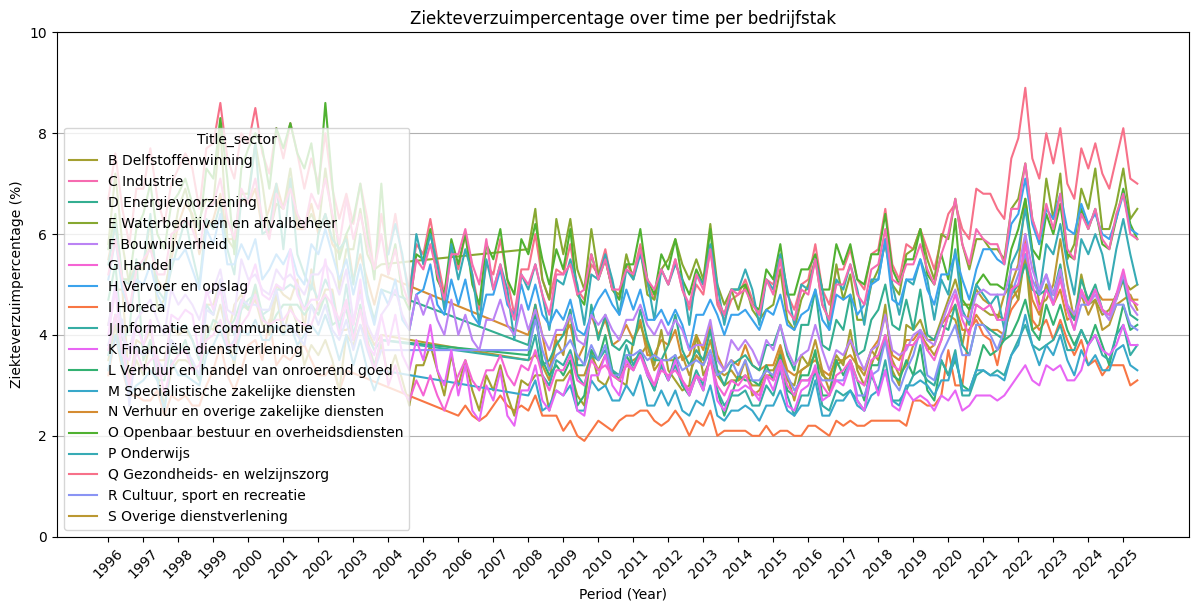

In [87]:
# Filter for CategoryGroupID == 1
df_plot = df_80072ned.filter(pl.col("CategoryGroupID") == 3)

# Ensure the relevant columns exist
if "Ziekteverzuimpercentage_1" not in df_plot.columns:
    raise ValueError("Column 'Ziekteverzuimpercentage_1' not found in DataFrame.")

# Create a 'period' column for x-axis (e.g., '2020Q1', '2020Q2', ...)
df_plot = df_plot.with_columns([
    (pl.col("year").cast(str) + "Q" + pl.col("quarter").cast(str)).alias("period")
]).sort(["year", "quarter"])

# Convert to pandas for seaborn
df_plot_pd = df_plot.to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot_pd, x='period', y='Ziekteverzuimpercentage_1', hue='Title_sector')

# Sort the legend alphabetically
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, title='Title_sector')

plt.xlabel("Period (Year)")
plt.ylabel("Ziekteverzuimpercentage (%)")
plt.title("Ziekteverzuimpercentage over time per bedrijfstak")
plt.tight_layout()
plt.ylim(0, 10)
plt.grid('major', axis='y')

# Limit x-axis labels to years
periods_unique = df_plot_pd['period'].unique()
years_unique = df_plot_pd.drop_duplicates(subset=['period'])['year'].values
xtick_positions = []
xtick_labels = []
current_year = None
for i, year in enumerate(years_unique):
    if year != current_year:
        # Find the index of this period in the full periods list
        period_idx = list(periods_unique).index(periods_unique[i])
        xtick_positions.append(period_idx)
        xtick_labels.append(str(year))
        current_year = year
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.show()



#### Create a time series plot using seaborn to show ziekteverzuim over the years per branch (category = 4)


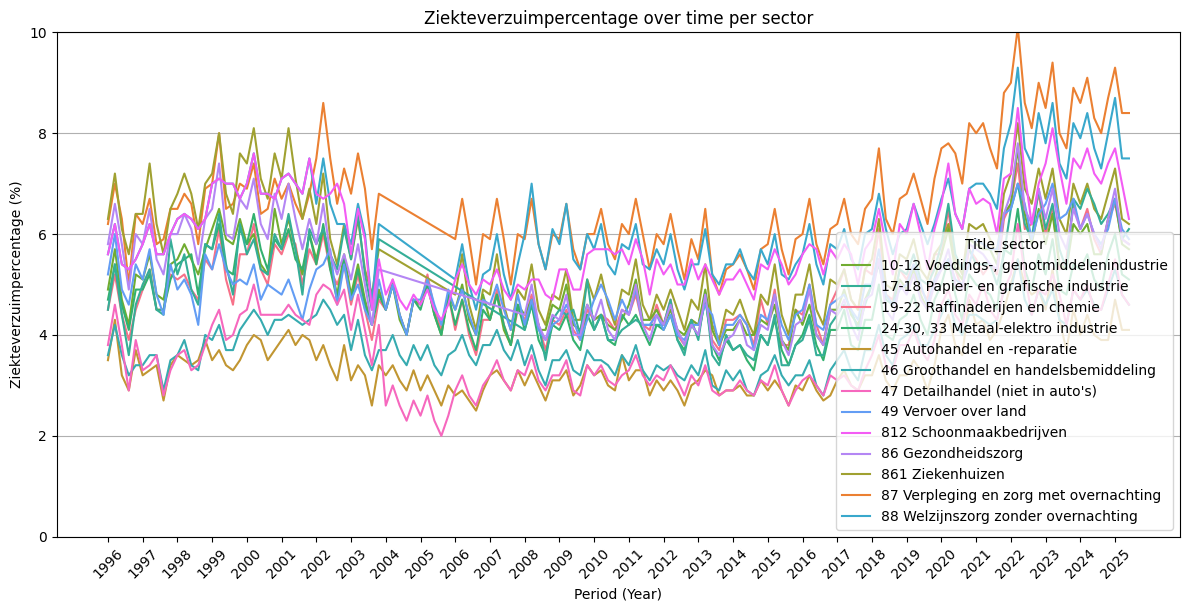

In [ ]:
# Filter for CategoryGroupID == 1
df_plot = df_80072ned.filter(pl.col("CategoryGroupID") == 4)

# Ensure the relevant columns exist
if "Ziekteverzuimpercentage_1" not in df_plot.columns:
    raise ValueError("Column 'Ziekteverzuimpercentage_1' not found in DataFrame.")

# Create a 'period' column for x-axis (e.g., '2020Q1', '2020Q2', ...)
df_plot = df_plot.with_columns([
    (pl.col("year").cast(str) + "Q" + pl.col("quarter").cast(str)).alias("period")
]).sort(["year", "quarter"])

# Convert to pandas for seaborn
df_plot_pd = df_plot.to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot_pd, x='period', y='Ziekteverzuimpercentage_1', hue='Title_sector')

# Sort the legend alphabetically
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, title='Title_sector')

plt.xlabel("Period (Year)")
plt.ylabel("Ziekteverzuimpercentage (%)")
plt.title("Ziekteverzuimpercentage over time per branch")
plt.tight_layout()
plt.ylim(0, 10)
plt.grid('major', axis='y')

# Limit x-axis labels to years
periods_unique = df_plot_pd['period'].unique()
years_unique = df_plot_pd.drop_duplicates(subset=['period'])['year'].values
xtick_positions = []
xtick_labels = []
current_year = None
for i, year in enumerate(years_unique):
    if year != current_year:
        # Find the index of this period in the full periods list
        period_idx = list(periods_unique).index(periods_unique[i])
        xtick_positions.append(period_idx)
        xtick_labels.append(str(year))
        current_year = year
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.show()



#### Create a time series plot using seaborn of the categories 5 (company size) over the years

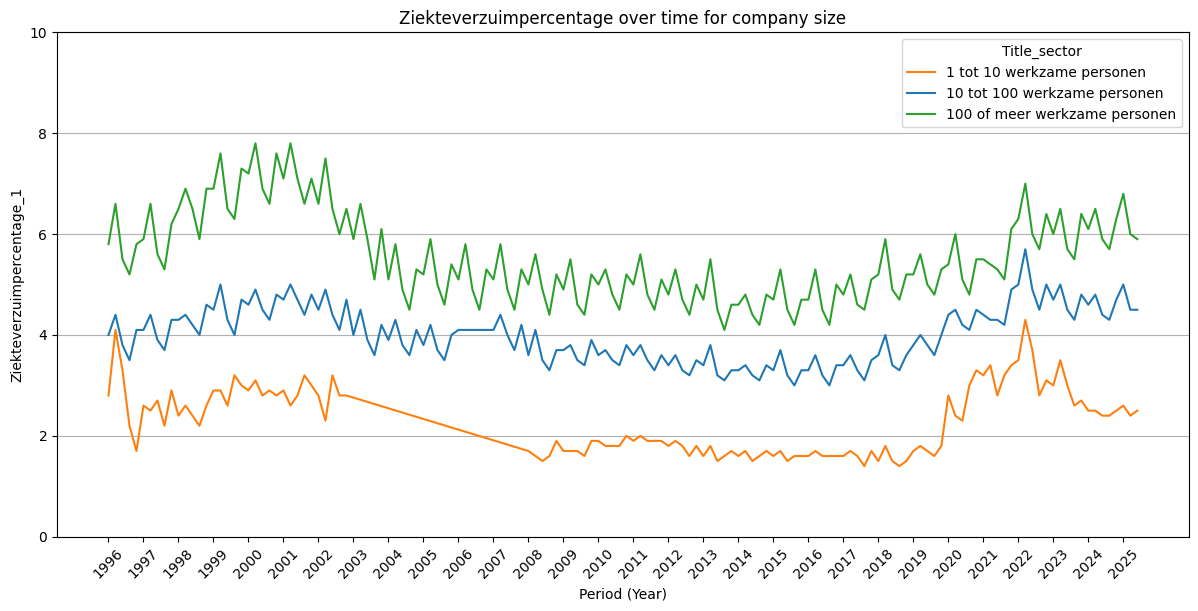

In [80]:
# Filter for CategoryGroupID == 5
df_plot = df_80072ned.filter(pl.col("CategoryGroupID") == 5)

# Ensure the relevant columns exist
if "Ziekteverzuimpercentage_1" not in df_plot.columns:
    raise ValueError("Column 'Ziekteverzuimpercentage_1' not found in DataFrame.")

# Create a 'period' column for x-axis (e.g., '2020Q1', '2020Q2', ...)
df_plot = df_plot.with_columns([
    (pl.col("year").cast(str) + "Q" + pl.col("quarter").cast(str)).alias("period")
]).sort(["year", "quarter"])

# Convert to pandas for seaborn
df_plot_pd = df_plot.to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot_pd, x='period', y='Ziekteverzuimpercentage_1', hue='Title_sector')

# Sort the legend alphabetically
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, title='Title_sector')

plt.xlabel("Period (Year)")
plt.ylabel("Ziekteverzuimpercentage_1")
plt.title("Ziekteverzuimpercentage over time for company size")
plt.tight_layout()
plt.ylim(0, 10)
plt.grid('major', axis='y')

# Limit x-axis labels to years
periods_unique = df_plot_pd['period'].unique()
years_unique = df_plot_pd.drop_duplicates(subset=['period'])['year'].values

xtick_positions = []
xtick_labels = []
current_year = None
for i, year in enumerate(years_unique):
    if year != current_year:
        # Find the index of this period in the full periods list
        period_idx = list(periods_unique).index(periods_unique[i])
        xtick_positions.append(period_idx)
        xtick_labels.append(str(year))
        current_year = year
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.show()



# Back-up code